In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers==4.37.1 optimum==1.16.2
!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/  # Use cu117 if on CUDA 11.7
!pip install langchain sentence-transformers

In [ ]:
!pip install autoawq

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import uuid
import torch
from scipy import stats as st
from transformers import set_seed
import random
import os
import gc
from scipy import stats

seed = 42
set_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

In [ ]:
path_to_work = "/content/drive/MyDrive/Interpretation/experiment_results/"
path_to_read = "/content/drive/MyDrive/Interpretation/"

# Download model

In [ ]:
model_name = "TheBloke/vicuna-7B-v1.5-GPTQ" 
#model_name = "TheBloke/Mistral-7B-v0.1-AWQ" 
#model_name = "TheBloke/Llama-2-7b-Chat-GPTQ" 

In [ ]:
num_layer = 32

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/874 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [ ]:
for params in model.parameters():
    print(params)

# Set prompt format and download data

For LLaMA and Mistral

In [ ]:
model_template = """[INST] <<SYS>>
{description}
<</SYS>>
{prompt}"""

In [ ]:
description = """Ты умеешь отвечать на вопросы на русском языке, опираясь на указанные данные."""

In [ ]:
prompt_template = """Кратко ответь на вопрос, используя данные тебе знания. [/INST]
Знания: {knowledge}
Вопрос: {question}
Ответ:
"""

For Vicuna

In [ ]:
model_template = """{description}

{prompt}"""

In [ ]:
description = """Ты умеешь отвечать на вопросы на русском языке, опираясь на указанные данные."""

In [ ]:
prompt_template = """USER: Кратко ответь на вопрос, используя данные тебе знания.
Знания: {knowledge}
Вопрос: {question}
ASSISTANT: Ответ:
"""

In [ ]:
name_knowledge= 'text'
name_question = 'question'
name_true_answers = ['true_1', 'true_2', 'true_3', 'true_5', 'true_5']
name_false_answers = ['false_1', 'false_2', 'false_3', 'false_4', 'false_5']

In [ ]:
data = pd.read_excel(path_to_read + 'balanced_muserc_with_rewriting.xlsx')
data

,text,question,true_1,true_2,true_3,true_4,true_5,false_1,false_2,false_3,false_4,false_5
0,Экспансия коммерческой литературы сужает круг ...,О чём идёт речь в начале текста?,"Речи идёт о книгах, без которых не возможно жить.",В тексте повествуется про важные книги.,В содержании текста акцентируется внимание на ...,"Тема обсуждения - это издания, без присутствия...","Здесь мы говорим о литературе, без которой жиз...",Речь идёт о фильмах ужасов.,В тексте идёт речь про музыку.,Речь идёт о мультиках про природу.,Обсуждаем тему хоррор-фильмов.,"Тема связана с анимационными фильмами, посвящё..."
1,Экспансия коммерческой литературы сужает круг ...,Какая метафора используется в тексте?,Он будет жевать литературный попкорн в полной ...,Эта метафора - литературный попкорн.,Этот образ можно сравнить с попкорном в литера...,Данная метафора аналогична литературному попко...,Эта выразительная фигура подобна попкорну в ми...,"Тише едешь, дальше будешь, как закат.","Читая книгу, как сова в ночи, без пауз, учишьс...","Метафора корабля, несущего читателя к сокровищ...","Чем медленнее двигаешься, тем больше достигнеш...","Обучаясь чтению подобно ночной сове, без едино..."
2,"""Британский актер и писатель Стивен Фрай объяв...",О чём сказано в записи победителя?,"Он уверен, что у людей есть всё, чтобы сделать...","Он верит, что мы можем построить лучший мир, н...","Его уверенность в том, что существует способ у...",Он убежден в возможности создать более соверше...,"Он держится веры в то, что наши усилия могут п...","Он думает, что люди могут изменить мир, если д...","Он думает, что людям вполне по силам испортить...","Он верит, что мир станет лучше, но для этого н...","По его мнению, для того чтобы люди смогли прео...","По его мнению, мир способен стать лучше, но дл..."
3,"Ещё недавно Векшин был, как говорили, чуть ли ...",Что украл Векшин в купе?,Векшин вдвоём с мастером «поездухи» Василием В...,"Будучи в купе поезда, Векшин вместе с о своим ...","Совместными усилиями, Векшин и Василий Василье...","Во время поездки в купе, Векшин и его друг Вас...","В сотрудничестве с мастером ""поездухи"", Васили...",Векшин вдвоём с мастером «поездухи» Василием В...,Векшин вдвоём с мастером «поездухи» Василием В...,"Будучи в купе поезда, Векшин вместе с о своим ...","Василий Васильевич и Векшин, работая в паре, п...","Во время поездки на поезде, Векшин в компании ..."
4,Федеральная антимонопольная служба (ФАС) плани...,О чём заявил в интервью РБК глава ведомства ФАС?,О цене на билеты на самолеты.,"О том, что планируется сделать одинаковую цену...",Об стоимости авиабилетов.,Появилась информация о намерениях ввести едину...,Было объявлено о планах установить идентичные ...,Что отменят рейсы в Италию.,"О том, что не будут подавать алкоголь на борту.",Авиасообщение с Италией будет прекращено.,О прекращении подачи алкогольных напитков во в...,Об отсутствии алкоголя в меню бортового обслуж...
...,...,...,...,...,...,...,...,...,...,...,...,...
195,"""Министерство культуры РФ готово выделить 125 ...",Кому и на что готов выделить Минкульт 125 милл...,Городу Курску на строительство цирка.,"Без цирка город не полноценен"",городу Курску"".",Для города Курска будет построен цирк.,Строительство циркового комплекса предусмотрен...,"Для того, чтобы город считался полноценным, в ...",В Москву на строительство рынка.,В город Москву на строительство зоопарка.,"Приехали в Москву, чтобы построить рынок.",Строительство зоологического сада запущено в М...,В столице России приступили к возведению зоопа...
196,"""Министерство культуры РФ готово выделить 125 ...",Куда готов выделить Минкульт 125 миллионов руб...,Городу Курску на строительство цирка.,Для постройки цирка в Курске.,Чтобы возвести цирк в городе Курск.,С целью создания циркового комплекса в Курске.,На строительство нового циркового здания в Кур...,В город Москву на строительство зоопарка.,В Москву на строительство рынка.,В столичный регион отправляются с целью постро...,В столицу прибывают для возведения торгового к...,В Мо

# Calculating cos_sim

In [ ]:
def calc_cos_sim_group(row, rows):
    cos_sim = []
    for r in rows:
          row_cos_sim = []
          for i in range(len(row['vector'])):
              cs = cosine_similarity(np.array(row['vector'][i].cpu().detach().numpy()).reshape(1, -1), np.array(r['vector'][i].cpu().detach().numpy()).reshape(1, -1))
              row_cos_sim.append(cs[0][0])
          cos_sim.append(row_cos_sim)
    cos_sim = np.array(cos_sim).T.tolist()
    mean_cos_sim = []
    for i in range(len(cos_sim)):
        mean_cos_sim.append(np.mean(cos_sim[i]))
    return mean_cos_sim

# Get hidden states

In [ ]:
def get_hidden_states(rows):
  prompt_vectors  = []
  for row in rows:
    input_text = row
    t_input = tokenizer(input_text, padding=True, return_tensors="pt").to("cuda")
    output = model(t_input['input_ids'], output_hidden_states = True)

    # output.hidden_states:
    #   len=1 [0]
    #     layers [1:33]
    #     batch [0]
    #     tokens [-1]
    #     vectors=4096

    sentence_embeddings = []
    # for hs in output.hidden_states[0][1:33]:
    for hs in output.hidden_states[1:33]:
        sentence_embeddings.append(hs[0][-1])

    prompt_vectors.append({"text":row, "vector": sentence_embeddings})
    torch.cuda.empty_cache()
    gc.collect()
  return prompt_vectors

# Main function

In [ ]:
def main_group(first_answers_hs, second_answers_hs, name, index): # name in [corr, wrong]

    cs_first_hs = []
    cs_second_hs = []
    for first_answers, second_answers in zip(first_answers_hs, second_answers_hs):

        sequences_cs_first_answer_second_group = []
        sequences_cs_first_answer_first_group = []
        sequences_text = []

        for idx in range(len(first_answers)):
            first_answer = first_answers[idx]
            sequences_text.append(first_answer['text'])


            cs_first_answer_second_group = calc_cos_sim_group(first_answer, second_answers)
            cs_first_answer_first_group = calc_cos_sim_group(first_answer, first_answers[:idx] + first_answers[idx+1:])

            sequences_cs_first_answer_second_group.append(cs_first_answer_second_group)
            sequences_cs_first_answer_first_group.append(cs_first_answer_first_group)


        df = pd.DataFrame(sequences_cs_first_answer_second_group)
        df.insert(0, "text", sequences_text)
        df.to_excel(path_to_work + "cs_"+name+"_answer_other_group_" + str(index) + ".xlsx", index=False)

        df = pd.DataFrame(sequences_cs_first_answer_first_group)
        df.insert(0, "text", sequences_text)
        df.to_excel(path_to_work + "cs_"+name+"_answer_self_group_" + str(index) + ".xlsx", index=False)

        cs_first_hs.append(sequences_cs_first_answer_first_group)
        cs_second_hs.append(sequences_cs_first_answer_second_group)
    return cs_first_hs, cs_second_hs

In [ ]:
def main_statistics(cos_sim_examples, group_for_compare):
    mean_cs_sequences = []
    mean_cs_comp_group = []
    idx_layer_min = []
    # idx_layer_max = []
    idx_diff_max = []
    idx_diff_min = []
    group_diffs = []
    for cos_sim_example, cos_sim_comp_exapmle in zip(cos_sim_examples, group_for_compare):
        mean_cs_sequence = np.mean(cos_sim_example, axis=0)
        mean_cs_sequences.append(np.mean(mean_cs_sequence))

        for sequences in cos_sim_example:
            idx_layer_min.append(np.argmin(sequences))
            # idx_layer_max.append(np.argmax(sequences))
            sequences_diff = [sequences[n]-sequences[n-1] for n in range(1,len(sequences))]
            idx_diff_max.append(np.argmax(sequences_diff))
            idx_diff_min.append(np.argmin(sequences_diff))
            # idx_layer_max.append(np.argmax(sequences_diff))

        mean_cs_comp = np.mean(cos_sim_comp_exapmle, axis=0)
        mean_cs_comp_group.append(mean_cs_comp)
        group_diff = [abs(mean_cs_sequence[n]-mean_cs_comp[n]) for n in range(0,len(mean_cs_sequence))]
        group_diffs.append(group_diff)
    stat = {"mean": mean_cs_sequences,
            "max": {
                    "value": max(mean_cs_sequences),
                    "index": np.argmax(mean_cs_sequences)},
            "min":{
                    "value": min(mean_cs_sequences),
                    "index": np.argmin(mean_cs_sequences)}
    }
    underfitting_criterion = {
            "abs_min": idx_layer_min,
            "diff_max": idx_diff_max,
            "diff_min": idx_diff_min,
            "group_diff": group_diffs
    }
    return stat, underfitting_criterion

# Execute

In [ ]:
knowledge = data[name_knowledge]
question = data[name_question]
correct_answers = data[name_true_answers]
wrong_answers = data[name_false_answers]
inputs_texts = []
prompts = []
for k, q in zip(knowledge, question):
  prompt = prompt_template.format(knowledge=k, question=q)
  input_text = model_template.format(description=description, prompt=prompt)
  prompts.append(input_text)

In [ ]:
correct_inputs = []
for i, row in correct_answers.iterrows():
    correct_input = []
    for answer in row:
        correct_input.append(prompts[i] + answer)
    correct_inputs.append(correct_input)
correct_inputs = pd.DataFrame(correct_inputs)
correct_inputs

,0,1,2,3,4
0,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
1,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
2,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
3,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
4,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
...,...,...,...,...,...
195,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
196,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
197,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
198,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...


In [ ]:
wrong_inputs = []
for i, row in wrong_answers.iterrows():
    wrong_input = []
    for answer in row:
        wrong_input.append(prompts[i] + answer)
    wrong_inputs.append(wrong_input)
wrong_inputs = pd.DataFrame(wrong_inputs)
wrong_inputs

,0,1,2,3,4
0,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
1,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
2,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
3,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
4,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
...,...,...,...,...,...
195,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
196,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
197,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...
198,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...,Ты умеешь отвечать на вопросы на русском языке...


In [ ]:
%%time
# %%debug
import pdb
cs_corr_cr = []
cs_corr_wr = []
cs_wrong_wr = []
cs_wrong_cr = []

for corr_example, wrong_example in zip(correct_inputs.iterrows(), wrong_inputs.iterrows()):
    i = corr_example[0]
    print(i)

    corr_answer = corr_example[1]
    wrong_answer = wrong_example[1]
    # pdb.set_trace()
    corr_answer_hs = get_hidden_states(corr_answer)
    wrong_answer_hs = get_hidden_states(wrong_answer)

    cs_cr_cr, cs_cr_wr = main_group([corr_answer_hs], [wrong_answer_hs], "corr", i)
    cs_corr_cr += cs_cr_cr
    cs_corr_wr += cs_cr_wr
    cs_wr_wr, cs_wr_cr = main_group([wrong_answer_hs], [corr_answer_hs], "wrong", i)
    cs_wrong_wr += cs_wr_wr
    cs_wrong_cr += cs_wr_cr

    del corr_answer_hs, wrong_answer_hs
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
stat_corr_cr, underfit_corr_cr = main_statistics(cs_corr_cr, cs_wrong_cr)
stat_corr_cr

In [ ]:
stat_wrong_wr, underfit_wrong_wr = main_statistics(cs_wrong_wr, cs_corr_wr)
stat_wrong_wr

In [ ]:
stat_corr_wr, underfit_corr_wr = main_statistics(cs_corr_wr, cs_wrong_wr)
stat_corr_wr

In [ ]:
stat_wrong_cr, underfit_wrong_cr = main_statistics(cs_wrong_cr, cs_corr_cr)
stat_wrong_cr

In [ ]:
df_results_stat_cs = pd.DataFrame()
df_results_stat_cs['wrong_wrong'] = stat_wrong_wr['mean']
df_results_stat_cs['corr_wrong'] = stat_corr_wr['mean']
df_results_stat_cs['wrong_corr'] = stat_wrong_cr['mean']
df_results_stat_cs['corr_corr'] = stat_corr_cr['mean']
df_results_stat_cs.to_excel("statistics_cos_sim.xlsx", index=False)
df_results_stat_cs

,wrong_wrong,corr_wrong,wrong_corr,corr_corr
0,0.747789,0.635662,0.635662,0.769035
1,0.701204,0.590184,0.590184,0.748073
2,0.750666,0.700067,0.700067,0.770288
3,0.789686,0.746459,0.746459,0.813573
4,0.794991,0.651444,0.651444,0.743488
...,...,...,...,...
195,0.717003,0.591953,0.591953,0.649690
196,0.760441,0.713735,0.713735,0.926072
197,0.772952,0.731476,0.731476,0.778109
198,0.696327,0.655168,0.655168,0.705769


In [ ]:
seq_stat = ['abs_min', 'diff_max', 'diff_min']
exp_stat = ['group_diff']
def save_uderfit_stat(data, name):
    seq_df = []
    exp_df = []
    for key in data:
        if key in seq_stat:
            seq_df.append(data[key])
        else:
            exp_df.append(data[key])
    seq_df = pd.DataFrame(np.transpose(seq_df), index=range(1000),columns=range(3))
    exp_df = pd.DataFrame(np.array(exp_df).reshape((200, 32)))#, index=range(32),columns=range(200)
    seq_df.to_excel(name+"_seq.xlsx", index=False)
    exp_df.to_excel(name+"_diff.xlsx", index=False)

In [ ]:
save_uderfit_stat(underfit_wrong_wr, "underfit_wrong_wr")
save_uderfit_stat(underfit_corr_wr, "underfit_corr_wr")
save_uderfit_stat(underfit_corr_cr, "underfit_corr_cr")
save_uderfit_stat(underfit_wrong_cr, "underfit_wrong_cr")

# t-test

In [ ]:
stats.levene(df_results_stat_cs['wrong_wrong'], df_results_stat_cs['wrong_corr'], center='mean')

LeveneResult(statistic=0.5849123342299348, pvalue=0.44484648368225277)

In [ ]:
stats.levene(df_results_stat_cs['corr_wrong'], df_results_stat_cs['corr_corr'], center="mean")

LeveneResult(statistic=2.0482294004548596, pvalue=0.15316803881048818)

In [ ]:
stats.ttest_ind(df_results_stat_cs['wrong_wrong'], df_results_stat_cs['wrong_corr'], equal_var=True)

TtestResult(statistic=7.50988351207921, pvalue=3.9289627531864386e-13, df=398.0)

In [ ]:
stats.ttest_ind(df_results_stat_cs['corr_corr'], df_results_stat_cs['corr_wrong'], equal_var=True)

TtestResult(statistic=15.308549319225143, pvalue=6.329953994579679e-42, df=398.0)

<Axes: >

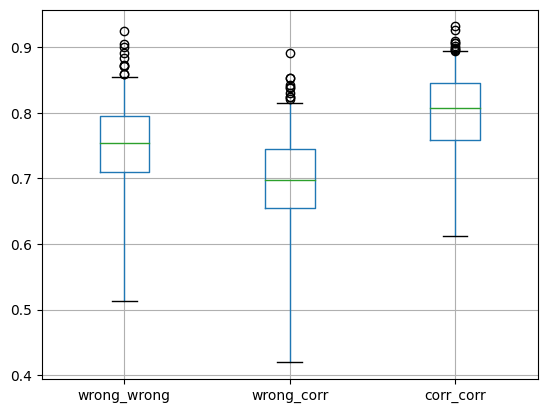

In [ ]:
df_results_stat_cs.boxplot(column=['wrong_wrong', 'wrong_corr', 'corr_corr'], whis=(0, 95))

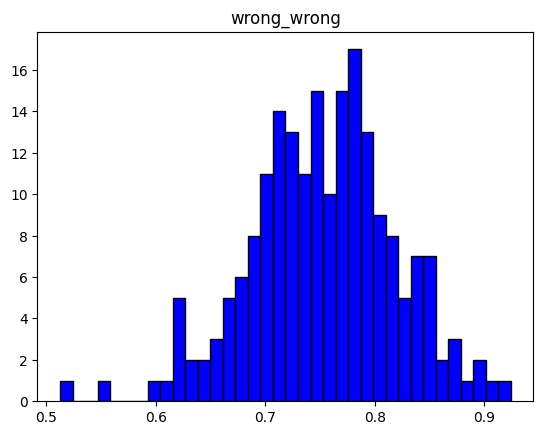

In [ ]:
import matplotlib.pyplot as plt

# matplotlib histogram
plt.hist(df_results_stat_cs['wrong_wrong'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.title('wrong_wrong')
plt.show()

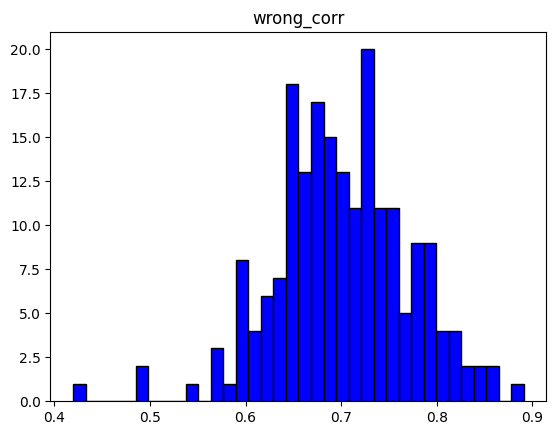

In [ ]:
plt.hist(df_results_stat_cs['wrong_corr'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.title('wrong_corr')
plt.show()

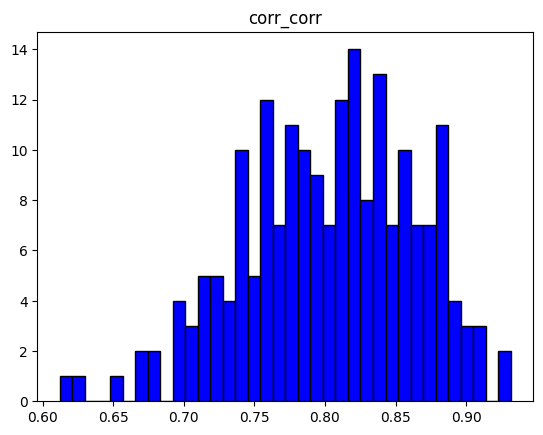

In [ ]:
plt.hist(df_results_stat_cs['corr_corr'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.title('corr_corr')
plt.show()